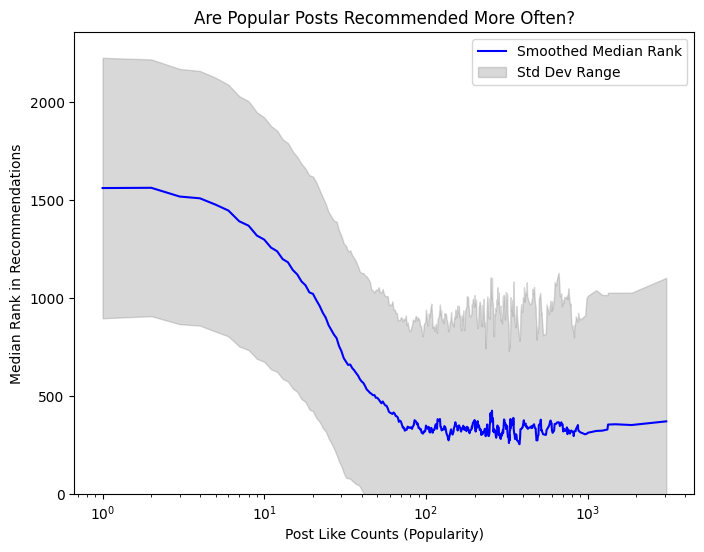

In [37]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# Load recommended posts
with open('recommended_posts.json', 'r') as file:
    data = json.load(file)

# Load interaction data (post like counts)
interaction_df = pd.read_csv('/home/sgan/private/DyGLib/processed_data/bluesky/ml_bluesky.csv')
post_like_counts = interaction_df['i'].value_counts().to_dict()  # Convert to dictionary for fast lookup

# Create a DataFrame to store rankings
rankings = []
for user_recs in data:
    for rank, post_id in enumerate(user_recs, start=1):  # Rank starts from 1 (not 0)
        rankings.append((post_id, rank))

# Convert rankings into DataFrame
rank_df = pd.DataFrame(rankings, columns=['post_id', 'rank'])

# Compute statistics: median rank, std deviation per post
rank_stats = rank_df.groupby('post_id')['rank'].agg(['median', 'std']).reset_index()

# Merge with popularity data (fill missing counts with 0)
rank_stats['popularity'] = rank_stats['post_id'].map(post_like_counts).fillna(0)

# Group by popularity (aggregate posts with the same like count)
agg_rank_stats = rank_stats.groupby('popularity').agg(
    median_rank=('median', 'median'),
    std_rank=('std', 'median')
).reset_index()

# Extract values for plotting
popularity = agg_rank_stats['popularity']
median_rank = agg_rank_stats['median_rank']
std_dev = agg_rank_stats['std_rank'].fillna(0)  # Fill NaN std with 0 to avoid errors

# Apply smoothing with a rolling average (window=5)
median_rank_smoothed = median_rank.rolling(window=5, min_periods=1).mean()
std_dev_smoothed = std_dev.rolling(window=5, min_periods=1).mean()

# Plot line plot with smoothed curve
plt.figure(figsize=(8, 6))
plt.plot(popularity, median_rank_smoothed, linestyle='-', label="Smoothed Median Rank", color='blue')

# Add standard deviation shading
plt.fill_between(popularity, 
                 median_rank_smoothed - std_dev_smoothed, 
                 median_rank_smoothed + std_dev_smoothed, 
                 color='gray', alpha=0.3, label="Std Dev Range")

# Log scale for popularity
plt.xscale('log')

# Prevent y-axis from going below 0
plt.ylim(bottom=0)

# Labels and title
plt.xlabel('Post Like Counts (Popularity)')
plt.ylabel('Median Rank in Recommendations')
plt.title('Are Popular Posts Recommended More Often?')
plt.legend()

# Save the figure as PNG
plt.savefig('rank_vs_popularity.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
np.percentile(list(post_like_counts.values()), 99)

np.float64(35.0)

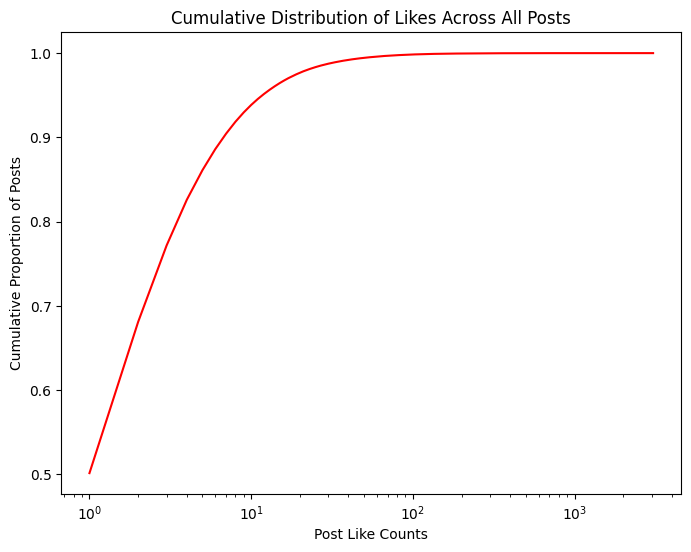

In [28]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# Load recommended posts
with open('recommended_posts.json', 'r') as file:
    data = json.load(file)

# Load interaction data (post like counts)
interaction_df = pd.read_csv('/home/sgan/private/DyGLib/processed_data/bluesky/ml_bluesky.csv')
post_like_counts = interaction_df['i'].value_counts().to_dict()  # Convert to dictionary for fast lookup
# Convert post_like_counts to DataFrame
likes_df = pd.DataFrame(list(post_like_counts.values()), columns=['like_count'])

# Aggregate and compute cumulative distribution of likes
likes_distribution = likes_df['like_count'].value_counts().sort_index().reset_index()
likes_distribution.columns = ['like_count', 'num_posts']
likes_distribution['cumulative_posts'] = likes_distribution['num_posts'].cumsum()
likes_distribution['cumulative_proportion'] = likes_distribution['cumulative_posts'] / likes_distribution['num_posts'].sum()

# Plot cumulative distribution of likes (ALL posts, not just recommended)
plt.figure(figsize=(8, 6))
plt.plot(likes_distribution['like_count'], likes_distribution['cumulative_proportion'], linestyle='-', color='red')

# Log scale for likes to better visualize distribution
plt.xscale('log')

# Labels and title
plt.xlabel('Post Like Counts')
plt.ylabel('Cumulative Proportion of Posts')
plt.title('Cumulative Distribution of Likes Across All Posts')

# Save the figure
plt.savefig('cumulative_like_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


count    4.097863e+07
mean     1.420138e+03
std      8.122432e+02
min      1.000000e+00
25%      7.460000e+02
50%      1.393000e+03
75%      2.084000e+03
max      3.471000e+03
Name: rank, dtype: float64


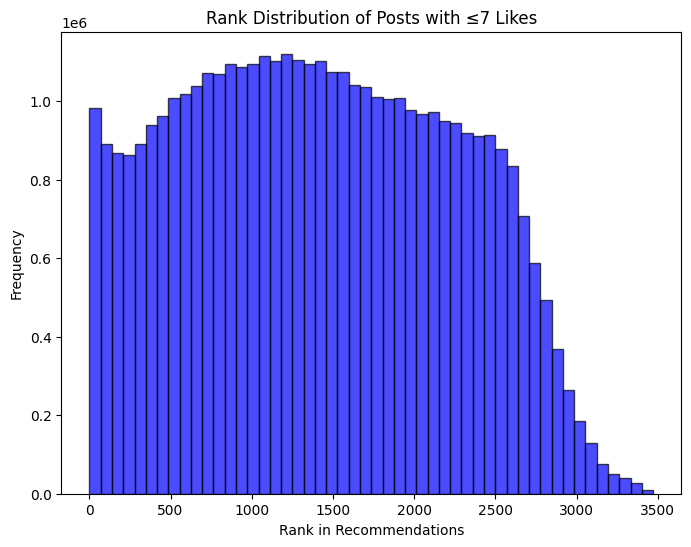

In [34]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# Load recommended posts
with open('recommended_posts.json', 'r') as file:
    data = json.load(file)

# Load interaction data (post like counts)
interaction_df = pd.read_csv('/home/sgan/private/DyGLib/processed_data/bluesky/ml_bluesky.csv')
post_like_counts = interaction_df['i'].value_counts().to_dict()  # Convert to dictionary for fast lookup

# Create a DataFrame to store rankings
rankings = []

for user_recs in data:
    for rank, post_id in enumerate(user_recs, start=1):  # Rank starts from 1 (not 0)
        rankings.append((post_id, rank))

# Convert rankings into DataFrame
rank_df = pd.DataFrame(rankings, columns=['post_id', 'rank'])

# Merge with popularity data
rank_df['popularity'] = rank_df['post_id'].map(post_like_counts).fillna(0)

# Filter for low-like posts (posts with ≤7 likes)
low_like_ranks = rank_df[rank_df['popularity'] <= 35]

# Compute statistics for ranks of low-like posts
low_like_rank_stats = low_like_ranks['rank'].describe()
print(low_like_rank_stats)

# Plot rank distribution for low-like posts
plt.figure(figsize=(8, 6))
plt.hist(low_like_ranks['rank'], bins=50, color='blue', alpha=0.7, edgecolor='black')

# Labels and title
plt.xlabel('Rank in Recommendations')
plt.ylabel('Frequency')
plt.title('Rank Distribution of Posts with ≤7 Likes')
plt.show()


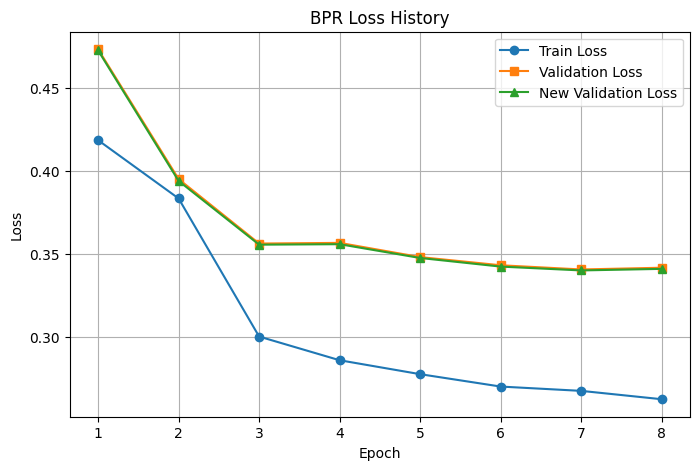

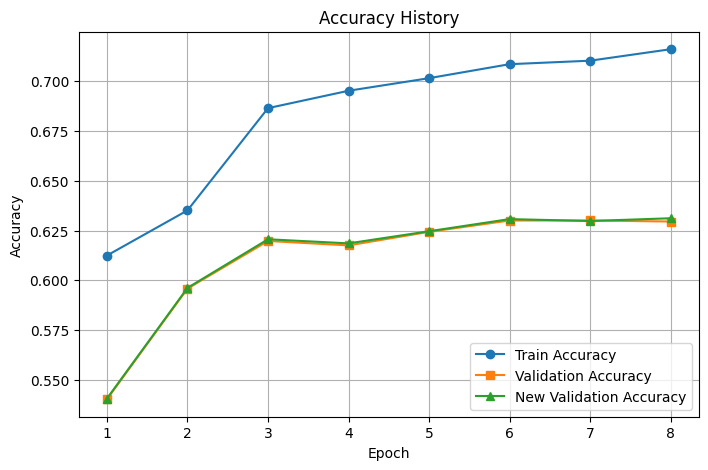

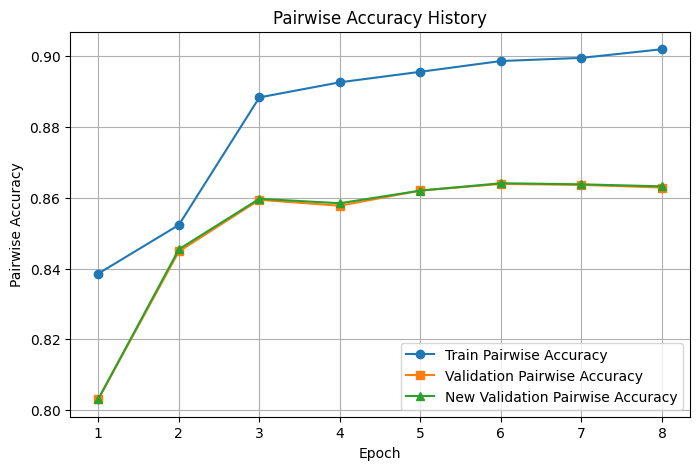

In [10]:
import json
import matplotlib.pyplot as plt

# Open and load JSON file
with open('training_results.json', 'r') as file:
    data = json.load(file)


# Create line plots for loss, accuracy, and pairwise accuracy

# Loss plot
# Define x-axis values starting from 1
epochs = list(range(1, len(data['train_loss_history']) + 1))

# Loss plot with x-axis labeled from 1 to number of epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs, data['train_loss_history'], label='Train Loss', marker='o')
plt.plot(epochs, data['val_loss_history'], label='Validation Loss', marker='s')
plt.plot(epochs, data['new_val_loss_history'], label='New Validation Loss', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BPR Loss History')
plt.xticks(epochs)  # Set x-axis labels to match epoch numbers
plt.legend()
plt.grid(True)
plt.savefig('loss.png')
plt.show()

# Accuracy plot with x-axis labeled from 1 to number of epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs, data['train_acc_history'], label='Train Accuracy', marker='o')
plt.plot(epochs, data['val_acc_history'], label='Validation Accuracy', marker='s')
plt.plot(epochs, data['new_val_acc_history'], label='New Validation Accuracy', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy History')
plt.xticks(epochs)  # Set x-axis labels to match epoch numbers
plt.legend()
plt.grid(True)
plt.savefig('acc.png')
plt.show()

# Pairwise accuracy plot with x-axis labeled from 1 to number of epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs, data['train_pairwise_acc_history'], label='Train Pairwise Accuracy', marker='o')
plt.plot(epochs, data['val_pairwise_acc_history'], label='Validation Pairwise Accuracy', marker='s')
plt.plot(epochs, data['new_val_pairwise_acc_history'], label='New Validation Pairwise Accuracy', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Pairwise Accuracy')
plt.title('Pairwise Accuracy History')
plt.xticks(epochs)  # Set x-axis labels to match epoch numbers
plt.legend()
plt.grid(True)
plt.savefig('pairwise_acc.png')
plt.show()


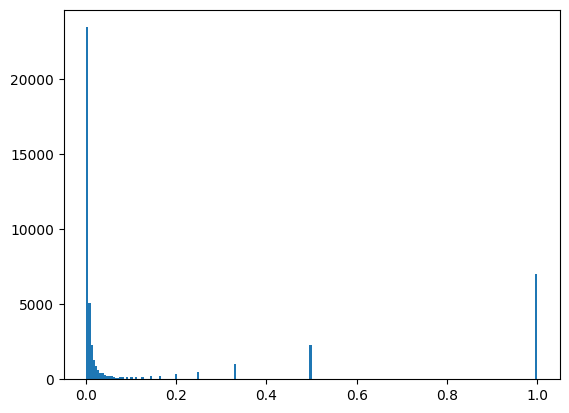

In [9]:
plt.hist(mrr_results, bins='auto')
plt.show()

In [18]:
1 / 0.0014992503748125937

667.0

In [19]:
np.min(mrr_results)

np.float64(0.00017346053772766696)

In [20]:
1 / 0.00017346053772766696

5765.0

In [2]:
import pandas as pd

import pickle

# Specify the path to your .pkl file
file_path = "/home/sgan/private/DyGLib/DG_data/bluesky/user_mapping.pkl"

# Open the file in read-binary mode and load the data
with open(file_path, "rb") as file:
    user_mapping = pickle.load(file)

user_max = max(user_mapping.values())

recommended_posts = pd.read_json('recommended_posts.json').T

In [3]:
recommended_posts.head()

,top_candidates,last_candidates
111076,"[2884274, 2996699, 2524720, 2524721, 4424637, ...","[4519438, 5599799, 335611, 1610885, 144221, 12..."
122684,"[5136602, 280743, 811690, 641513, 641955, 2503...","[335643, 335558, 1615176, 415198, 5516526, 335..."
136401,"[1525773, 4685389, 2421941, 136401]","[415162, 335639, 335630, 1757963, 335655, 1594..."
144221,"[1283065, 132476, 1301668, 167106, 1149059, 15...","[5101644, 3615310, 3996774, 1977823, 2222221, ..."
146879,"[2339177, 146879]","[1057996, 1248170, 335633, 2060672, 335667, 15..."


In [4]:
# Compute the value to subtract
subtract_value = 2 + user_max

# Function to subtract from the candidates
def adjust_candidates(candidate_list):
    return [candidate - subtract_value for candidate in candidate_list]

# Apply transformation to both 'top_candidates' and 'last_candidates'
recommended_posts['top_candidates'] = recommended_posts['top_candidates'].apply(adjust_candidates)
recommended_posts['last_candidates'] = recommended_posts['last_candidates'].apply(adjust_candidates)
recommended_posts.index = recommended_posts.index - subtract_value

# Display the updated DataFrame
recommended_posts.head()

,top_candidates,last_candidates
4708,"[2777906, 2890331, 2418352, 2418353, 4318269, ...","[4413070, 5493431, 229243, 1504517, 37853, 114..."
16316,"[5030234, 174375, 705322, 535145, 535587, 2396...","[229275, 229190, 1508808, 308830, 5410158, 229..."
30033,"[1419405, 4579021, 2315573, 30033]","[308794, 229271, 229262, 1651595, 229287, 1488..."
37853,"[1176697, 26108, 1195300, 60738, 1042691, 4911...","[4995276, 3508942, 3890406, 1871455, 2115853, ..."
40511,"[2232809, 40511]","[951628, 1141802, 229265, 1954304, 229299, 147..."


In [14]:
2941346 - subtract_value

np.int64(2834978)

In [6]:
# Specify the path to your .pkl file
file_path = "/home/sgan/private/DyGLib/DG_data/bluesky/post_mapping.pkl"

# Open the file in read-binary mode and load the data
with open(file_path, "rb") as file:
    post_mapping = pickle.load(file)

In [15]:
# Get the list of top candidates from recommended_posts
top_candidates = recommended_posts.loc[2834978]['top_candidates']
last_candidates = recommended_posts.loc[2834978]['last_candidates']

# Find matching keys for each value while preserving order
top_matching_keys = [key for value in top_candidates for key, v in post_mapping.items() if v == value]
last_matching_keys = [key for value in last_candidates for key, v in post_mapping.items() if v == value]

# Function to generate Bluesky URLs
def generate_bsky_urls(post_keys):
    return [f"https://bsky.app/profile/{key.split('_')[0]}/post/{key.split('_')[1]}" for key in post_keys]

# Generate URLs
top_post_urls = generate_bsky_urls(top_matching_keys)
last_post_urls = generate_bsky_urls(last_matching_keys)

# Print or use the URLs
print("Top Post URLs:")
for url in top_post_urls:
    print(url)

print("\nLast Post URLs:")
for url in last_post_urls:
    print(url)

Top Post URLs:
https://bsky.app/profile/did:plc:spctzvw6tk5slkjpbbhlncpj/post/3jy5efib24t2r
https://bsky.app/profile/did:plc:nukg7mqku65kfll7cqs6psgt/post/3jy5crdo5ft2r
https://bsky.app/profile/did:plc:pa653fmiorv7gccg4wkdhq5s/post/3jy5efwdrx22j
https://bsky.app/profile/did:plc:ddcdpvayapxexb26u6z3zlac/post/3jy5cy4mcsw2t
https://bsky.app/profile/did:plc:bw7yi2j5f7ndhemwcleiblis/post/3jy5crue2eh2i

Last Post URLs:
https://bsky.app/profile/did:plc:llmmp2zjelsipjvblo7v6hxi/post/3jy4vot3boo2t
https://bsky.app/profile/did:plc:s3e7wq745aurts6sqn2wxsmz/post/3jy5ds24ms22m
https://bsky.app/profile/did:plc:npk4h43prkk6mlxt2lqquvug/post/3jy5dzc7ix32r
https://bsky.app/profile/did:plc:phkckrkphw4ycjsoptgozooz/post/3jy5d2yrsm52f
https://bsky.app/profile/did:plc:vexqhohs5ojhy3xrj44j2cap/post/3jy5bwuaiqt2r
https://bsky.app/profile/did:plc:f3ixoayf7kham4t2razfzf5i/post/3jy5det4x6n25
https://bsky.app/profile/did:plc:tkyy33ng5ogqglb65mg2ott4/post/3jy5dwkxry62d
https://bsky.app/profile/did:plc:npk4h43prkk

In [2]:
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

node_feat = np.load('/home/sgan/private/DyGLib/processed_data/bluesky/ml_bluesky_node.npy')

with open('recommended_posts.json', 'r') as file:
    data = json.load(file)

intra_list_distance = []

for d in data:
    top_30 = d[:10]
    top_30_features = node_feat[top_30]  # Extract their feature vectors
    
    # Compute cosine similarity between all pairs
    similarity_matrix = cosine_similarity(top_30_features)
    
    # Compute mean pairwise distance (1 - similarity)
    mean_distance = 1 - np.mean(similarity_matrix)
    
    intra_list_distance.append(mean_distance)

print(np.mean(intra_list_distance))

0.5540016593610889


In [1]:
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

node_feat = np.load('/home/sgan/private/DyGLib/processed_data/bluesky/ml_bluesky_node.npy')

with open('recommended_posts.json', 'r') as file:
    data = json.load(file)

intra_list_distance = []

for d in data:
    top_30 = d[:10]
    top_30_features = node_feat[top_30]  # Extract their feature vectors
    
    # Compute cosine similarity between all pairs
    similarity_matrix = cosine_similarity(top_30_features)
    
    # Compute mean pairwise distance (1 - similarity)
    mean_distance = 1 - np.mean(similarity_matrix)
    
    intra_list_distance.append(mean_distance)

print(np.mean(intra_list_distance))

0.558899761244344


In [1]:
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load node features
node_feat = np.load('/home/sgan/private/DyGLib/processed_data/bluesky/ml_bluesky_node.npy')

# Load recommended posts
with open('recommended_posts.json', 'r') as file:
    data = json.load(file)

# Initialize list to store ILD@k values
intra_list_distance = []
k = 10  # Set k for ILD@k

for d in data:
    top_k = d[:k]  # Get top-k recommended items
    top_k_features = node_feat[top_k]  # Extract their feature vectors
    
    # Compute cosine similarity between all pairs
    similarity_matrix = cosine_similarity(top_k_features)
    
    # Convert similarity to distance (1 - similarity)
    distance_matrix = 1 - similarity_matrix
    
    # Exclude diagonal (self-similarity) by using upper triangle only
    num_pairs = k * (k - 1)  # Number of unique pairs
    mean_distance = np.sum(distance_matrix) / num_pairs  # ILD@k formula
    
    intra_list_distance.append(mean_distance)

# Compute overall ILD@k
print("ILD@k:", np.mean(intra_list_distance))


ILD@k: 0.6155573992900987


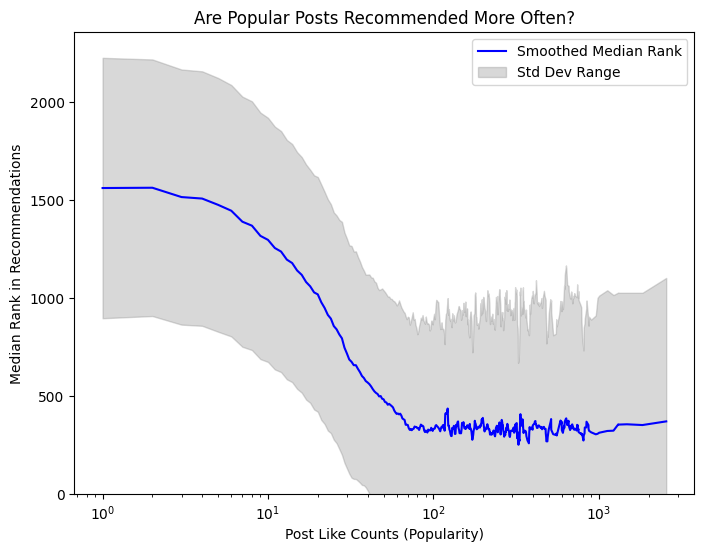

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# Load recommended posts
with open('recommended_posts.json', 'r') as file:
    data = json.load(file)

# Load interaction data (post like counts)
interaction_df = pd.read_csv('/home/sgan/private/DyGLib/processed_data/bluesky/ml_bluesky.csv')
interaction_df = interaction_df[interaction_df['ts']<1687549646.0]
post_like_counts = interaction_df['i'].value_counts().to_dict()  # Convert to dictionary for fast lookup

# Create a DataFrame to store rankings
rankings = []
for user_recs in data:
    for rank, post_id in enumerate(user_recs, start=1):  # Rank starts from 1 (not 0)
        rankings.append((post_id, rank))

# Convert rankings into DataFrame
rank_df = pd.DataFrame(rankings, columns=['post_id', 'rank'])

# Compute statistics: median rank, std deviation per post
rank_stats = rank_df.groupby('post_id')['rank'].agg(['median', 'std']).reset_index()

# Merge with popularity data (fill missing counts with 0)
rank_stats['popularity'] = rank_stats['post_id'].map(post_like_counts).fillna(0)

# Group by popularity (aggregate posts with the same like count)
agg_rank_stats = rank_stats.groupby('popularity').agg(
    median_rank=('median', 'median'),
    std_rank=('std', 'median')
).reset_index()

# Extract values for plotting
popularity = agg_rank_stats['popularity']
median_rank = agg_rank_stats['median_rank']
std_dev = agg_rank_stats['std_rank'].fillna(0)  # Fill NaN std with 0 to avoid errors

# Apply smoothing with a rolling average (window=5)
median_rank_smoothed = median_rank.rolling(window=5, min_periods=1).mean()
std_dev_smoothed = std_dev.rolling(window=5, min_periods=1).mean()

# Plot line plot with smoothed curve
plt.figure(figsize=(8, 6))
plt.plot(popularity, median_rank_smoothed, linestyle='-', label="Smoothed Median Rank", color='blue')

# Add standard deviation shading
plt.fill_between(popularity, 
                 median_rank_smoothed - std_dev_smoothed, 
                 median_rank_smoothed + std_dev_smoothed, 
                 color='gray', alpha=0.3, label="Std Dev Range")

# Log scale for popularity
plt.xscale('log')

# Prevent y-axis from going below 0
plt.ylim(bottom=0)

# Labels and title
plt.xlabel('Post Like Counts (Popularity)')
plt.ylabel('Median Rank in Recommendations')
plt.title('Are Popular Posts Recommended More Often?')
plt.legend()

# Save the figure as PNG
plt.savefig('rank_vs_popularity.png', dpi=300, bbox_inches='tight')
plt.show()